
# interpolation of surface obs to grid; scale decomposition following Maddox (1980)

Download surface data from IEM (optional), interpolate temperature and pressure to grid
Following Maddox (1980), apply Barnes analysis with different settings to isolate mesoscale perturbations

Adapted from: https://unidata.github.io/MetPy/latest/examples/gridding/Wind_SLP_Interpolation.html

Maddox (1980): https://journals.ametsoc.org/view/journals/mwre/108/8/1520-0493_1980_108_1108_aotfsm_2_0_co_2.xml


Imports

In [1]:
%matplotlib inline

from __future__ import print_function
import json
import time
import datetime
import pandas as pd

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from metpy.calc import wind_components
from metpy.calc import reduce_point_density
from metpy.cbook import get_test_data
from metpy.interpolate import interpolate_to_grid, inverse_distance_to_grid, remove_nan_observations
from metpy.plots import add_metpy_logo, current_weather, sky_cover, StationPlot
from metpy.units import units
from metpy.io import metar

### Define start and end time for download, and the time you want to plot

In [2]:
startts = datetime.datetime(2020, 8, 10, 18)
endts = datetime.datetime(2020, 8, 10,23)
interval = datetime.timedelta(hours=5)

this_time = pd.Timestamp(2020,8,10,21) ### this is the time you want to plot

## First get ASOS data from IEM -- if we already have data, can skip ahead to "Read in data" cell

In [3]:
# Python 2 and 3: alternative 4
try:
    from urllib.request import urlopen
except ImportError:
    from urllib2 import urlopen

# Number of attempts to download data
MAX_ATTEMPTS = 6
# HTTPS here can be problematic for installs that don't have Lets Encrypt CA
SERVICE = "http://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?"


def download_data(uri):
    """Fetch the data from the IEM

    The IEM download service has some protections in place to keep the number
    of inbound requests in check.  This function implements an exponential
    backoff to keep individual downloads from erroring.

    Args:
      uri (string): URL to fetch

    Returns:
      string data
    """
    attempt = 0
    while attempt < MAX_ATTEMPTS:
        try:
            data = urlopen(uri, timeout=300).read().decode("utf-8")
            if data is not None and not data.startswith("ERROR"):
                return data
        except Exception as exp:
            print("download_data(%s) failed with %s" % (uri, exp))
            time.sleep(5)
        attempt += 1

    print("Exhausted attempts to download, returning empty data")
    return ""


def get_stations_from_filelist(filename):
    """Build a listing of stations from a simple file listing the stations.

    The file should simply have one station per line.
    """
    stations = []
    for line in open(filename):
        stations.append(line.strip())
    return stations


def get_stations_from_networks():
    """Build a station list by using a bunch of IEM networks."""
    stations = []
    states = """AK AL AR AZ CA CO CT DE FL GA HI IA ID IL IN KS KY LA MA MD ME
     MI MN MO MS MT NC ND NE NH NJ NM NV NY OH OK OR PA RI SC SD TN TX UT VA VT
     WA WI WV WY"""
    # IEM quirk to have Iowa AWOS sites in its own labeled network
    networks = ["AWOS"]
    for state in states.split():
        networks.append("%s_ASOS" % (state,))

    for network in networks:
        # Get metadata
        uri = (
            "https://mesonet.agron.iastate.edu/geojson/network/%s.geojson"
        ) % (network,)
        data = urlopen(uri)
        jdict = json.load(data)
        for site in jdict["features"]:
            stations.append(site["properties"]["sid"])
    return stations


def download_alldata(startts,endts,interval):
    """An alternative method that fetches all available data.

    Service supports up to 24 hours worth of data at a time."""
    # timestamps in UTC to request data for
    startts = startts
    endts = endts
    interval = interval

    ## adding "report type=2" here filters out MADIS obs and keeps only the routine/speci obs
    service = SERVICE + "data=all&tz=Etc/UTC&format=comma&latlon=yes&report_type=2&"

    now = startts
    while now < endts:
        thisurl = service
        thisurl += now.strftime("year1=%Y&month1=%m&day1=%d&")
        thisurl += (now + interval).strftime("year2=%Y&month2=%m&day2=%d&")
        print("Downloading: %s" % (now,))
        data = download_data(thisurl)
        outfn = "%s.csv" % (now.strftime("%Y%m%d"),)
        with open(outfn, "w") as fh:
            fh.write(data)
        now += interval


def main():
    """Our main method"""
    # timestamps in UTC to request data for
    #startts = datetime.datetime(2012, 8, 1)
    #endts = datetime.datetime(2012, 9, 1)

    ## adding "report type=2" here filters out MADIS obs and keeps only the routine/speci obs
    service = SERVICE + "data=all&tz=Etc/UTC&format=comma&latlon=yes&report_type=2&"

    service += startts.strftime("year1=%Y&month1=%m&day1=%d&")
    service += endts.strftime("year2=%Y&month2=%m&day2=%d&")

    # Two examples of how to specify a list of stations
    stations = get_stations_from_networks()
    # stations = get_stations_from_filelist("mystations.txt")
    for station in stations:
        uri = "%s&station=%s" % (service, station)
        print("Downloading: %s" % (station,))
        data = download_data(uri)
        outfn = "%s_%s_%s.csv" % (
            station,
            startts.strftime("%Y%m%d%H%M"),
            endts.strftime("%Y%m%d%H%M"),
        )
        out = open(outfn, "w")
        out.write(data)
        out.close()


if __name__ == "__main__":
    download_alldata(startts,endts,interval)
    # main()


Downloading: 2020-08-10 18:00:00


Read in the csv file

In [4]:
sfc_data = pd.read_csv(startts.strftime("%Y%m%d")+".csv", skiprows=5,
                   infer_datetime_format=True, parse_dates=['valid'])

print("working on "+this_time.strftime("%Y-%m-%d %H:%M"))

## filter the data down to 10 minutes before to 1 minute after this time 
## (ASOS obs are typically reported at 5-8 mins before the nominal hour)
data = sfc_data.set_index('valid')[(this_time - pd.Timedelta('10 minutes')).strftime("%Y-%m-%d %H:%M"):(this_time + pd.Timedelta('1 minutes')).strftime("%Y-%m-%d %H:%M")]

## write this back to a txt file with just the metars
data['metar'].to_csv("metar_"+this_time.strftime("%Y%m%d_%H%M")+".txt",index=None)

working on 2020-08-10 21:00


## Read in data (can skip to here if we already have a file with METARs in it)



In [5]:
#data = metar.parse_metar_file('metar_20211211_0300.txt')
data = metar.parse_metar_file("metar_"+this_time.strftime("%Y%m%d_%H%M")+".txt",
                             year=this_time.year, month=this_time.month)

# Drop rows with missing winds
data = data.dropna(how='any', subset=['wind_direction', 'wind_speed'])


Take a quick look at the data we're using. 

In [6]:
data

,station_id,latitude,longitude,elevation,date_time,wind_direction,wind_speed,wind_gust,visibility,current_wx1,...,air_temperature,dew_point_temperature,altimeter,current_wx1_symbol,current_wx2_symbol,current_wx3_symbol,remarks,air_pressure_at_sea_level,eastward_wind,northward_wind
station_id,,,,,,,,,,,,,,,,,,,,,
EGPB,EGPB,59.87,-1.30,5.0,2020-08-10 20:50:00,110.0,5.0,NaN,9999.000,NaN,...,14.0,12.0,30.21,0,0,0,NOSIG,1023.30,-4.698463,1.710101
EGCC,EGCC,53.35,-2.27,78.0,2020-08-10 20:50:00,60.0,7.0,NaN,9999.000,NaN,...,23.0,17.0,29.97,0,0,0,NOSIG,1015.04,-6.062178,-3.500000
EGHH,EGHH,50.78,-1.83,11.0,2020-08-10 20:50:00,140.0,2.0,NaN,10000.000,NaN,...,22.0,18.0,29.94,0,0,0,,1014.27,-1.285575,1.532089
EGLL,EGLL,51.48,-0.45,24.0,2020-08-10 20:50:00,100.0,6.0,NaN,9999.000,NaN,...,26.0,16.0,29.94,0,0,0,NOSIG,1014.19,-5.908847,1.041889
EGWU,EGWU,51.55,-0.42,40.0,2020-08-10 20:50:00,100.0,7.0,NaN,10000.000,NaN,...,26.0,16.0,29.94,0,0,0,NOSIG RMK BLU BLU,1014.12,-6.893654,1.215537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KGUS,KGUS,40.63,-86.15,247.0,2020-08-10 21:01:00,230.0,13.0,NaN,16093.440,NaN,...,31.0,26.0,29.89,0,0,0,AO2 CIG 025 RWY05 SLP118 $,1010.84,9.958578,8.356239
KGRK,KGRK,31.07,-97.83,309.0,2020-08-10 21:01:00,120.0,16.0,23.0,16093.440,NaN,...,37.0,18.0,29.96,0,0,0,AO2 WSHFT 2049 SLP132,1012.10,-13.856406,8.000000
KMUO,KMUO,43.03,-115.87,913.0,2020-08-10 21:01:00,350.0,14.0,18.0,16093.440,NaN,...,31.0,1.0,30.00,0,0,0,AO2 WSHFT 2058 SLP132 $,1009.34,2.431074,-13.787309


In the August 2020 derecho example, the data from KCID (Cedar Rapids) is bad at this time; remove it. (Can comment out this line if plotting a different case.)

In [7]:
data = data.drop(data[data.station_id=="KCID"].index)

This METAR dataset includes surface data from around the world, but the interpolation method can sometimes fail when getting close to the poles, etc. So we'll subset the data down to the general region of North America. 

In [8]:
## subset to -50 to -150 longitude and 15-70 latitude 
#data = data[(data.longitude < -50) & (data.longitude > -150) & (data.latitude > 15) & (data.latitude < 70)]
data = data[(data.longitude < -75) & (data.longitude > -102) & (data.latitude > 30) & (data.latitude < 55)]


Set up the map projection and plot bounds

In [9]:
to_proj = ccrs.AlbersEqualArea(central_longitude=-95., central_latitude=40.)
#to_proj = ccrs.LambertConformal(central_longitude=-105, central_latitude=35,
#                             standard_parallels=[35])

proj = to_proj

## bounds for maps
latlon_bounds = (-98.,-84.5,36,44)

#### First plot just the surface map (no interpolation, etc.), just a blank surface chart

If desired, can thin the station data with reduce_point_density for this chart (will create a separate dataframe though as we'll want all the data for the interpolation later

In [10]:
# Use the Cartopy map projection to transform station locations to the map and
# then refine the number of stations plotted by setting a 150km radius
point_locs = proj.transform_points(ccrs.PlateCarree(), data['longitude'].values,
                                   data['latitude'].values)
data_thin = data[reduce_point_density(point_locs, 45000.)]

/Users/rschumac/mambaforge/envs/ats641_2023/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/rschumac/mambaforge/envs/ats641_2023/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


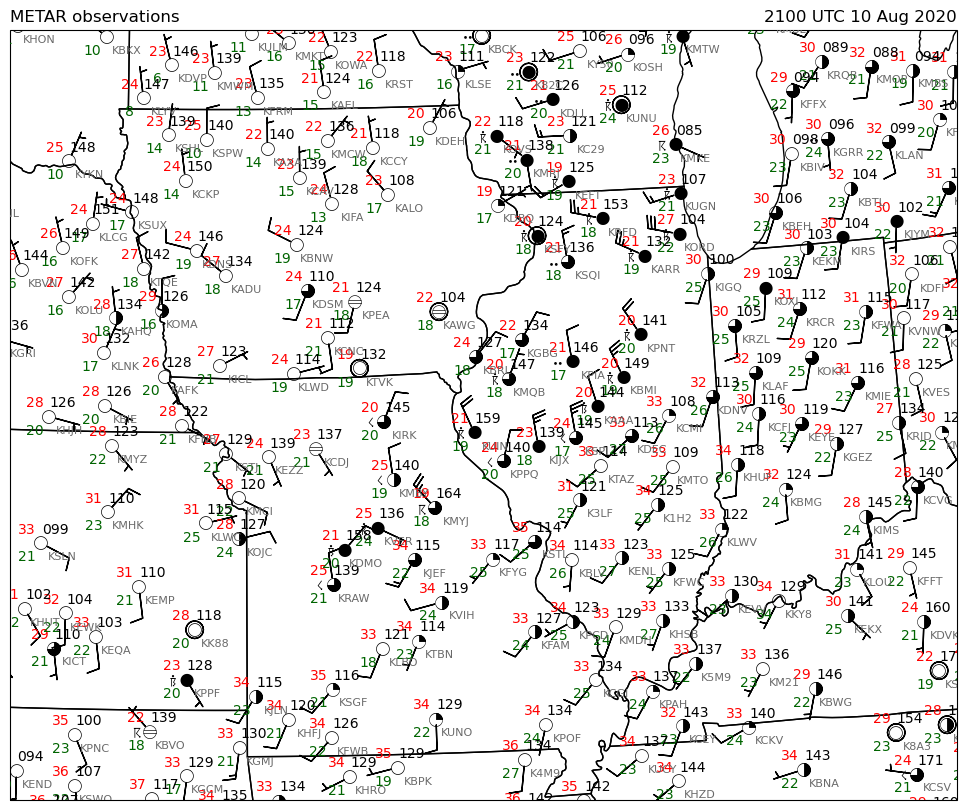

In [11]:
# Change the DPI of the resulting figure. Higher DPI drastically improves the
# look of the text rendering.
plt.rcParams['savefig.dpi'] = 255

# Create the figure and an axes set to the projection.
fig = plt.figure(figsize=(20, 10))
#add_metpy_logo(fig, 1100, 300, size='large')
ax = fig.add_subplot(1, 1, 1, projection=proj)

# Add some various map elements to the plot to make it recognizable.
#ax.add_feature(cfeature.LAND)
#ax.add_feature(cfeature.OCEAN)
#ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS)

# Set plot bounds
#ax.set_extent((-118, -73, 23, 50))
#ax.set_extent((-108,-73, 23, 50))
#ax.set_extent((-97.5,-84,37,44.25))
ax.set_extent(latlon_bounds)

#
# Here's the actual station plot
#

# Start the station plot by specifying the axes to draw on, as well as the
# lon/lat of the stations (with transform). We also the fontsize to 12 pt.
stationplot = StationPlot(ax, data_thin['longitude'].values, data_thin['latitude'].values,
                          clip_on=True, transform=ccrs.PlateCarree(), fontsize=10)

# Plot the temperature and dew point to the upper and lower left, respectively, of
# the center point. Each one uses a different color.
stationplot.plot_parameter('NW', data_thin['air_temperature'].values, color='red')
stationplot.plot_parameter('SW', data_thin['dew_point_temperature'].values,
                           color='darkgreen')

# A more complex example uses a custom formatter to control how the sea-level pressure
# values are plotted. This uses the standard trailing 3-digits of the pressure value
# in tenths of millibars.
stationplot.plot_parameter('NE', data_thin['air_pressure_at_sea_level'].values,
                           formatter=lambda v: format(10 * v, '.0f')[-3:])

# Plot the cloud cover symbols in the center location. This uses the codes made above and
# uses the `sky_cover` mapper to convert these values to font codes for the
# weather symbol font.
stationplot.plot_symbol('C', data_thin['cloud_coverage'].values, sky_cover)

# Same this time, but plot current weather to the left of center, using the
# `current_weather` mapper to convert symbols to the right glyphs.
stationplot.plot_symbol('W', data_thin['current_wx1_symbol'].values, current_weather)

# Add wind barbs
stationplot.plot_barb(data_thin['eastward_wind'].values, data_thin['northward_wind'].values,
                     length=6)

# Also plot the actual text of the station id. Instead of cardinal directions,
# plot further out by specifying a location of 2 increments in x and 0 in y.
stationplot.plot_text((1.5, -1), data_thin['station_id'].values, fontsize=8, color='dimgray')

plt.title('METAR observations', loc='left')
plt.title(this_time.strftime("%H%M UTC %d %b %Y"), loc='right')

plt.show()

fig.savefig("surface_"+this_time.strftime("%Y%m%d_%H%M")+".png", bbox_inches='tight', facecolor='white', transparent=False)

Now move on to the interpolation. First, project the lon/lat locations to our final projection



In [12]:
lon = data['longitude'].values
lat = data['latitude'].values
xp, yp, _ = to_proj.transform_points(ccrs.Geodetic(), lon, lat).T

### Temperature interpolation: We do three different interpolations here using MetPy: a 'default' Barnes analysis which also establishes a grid; then two Barnes analyses with settings as in Maddox (1980). After those, can calculate the bandpass field which isolates the mesoscale perturbations

In [13]:
x_masked, y_masked, t = remove_nan_observations(xp, yp, data['air_temperature'].values)

hres = 25 ## grid spacing (km)

### first generate the grid with the default barnes settings
tempx, tempy, temp = interpolate_to_grid(x_masked,y_masked,t, interp_type='barnes',hres=hres*1000.,
                                         #kappa_star = 10, 
                                         search_radius = 10000000)
                                         #gamma = 0.5)

#### Maddox (1980) F1
c_km2 = 5000 ### in km^2
g = 0.3  ## g or gamma value
c = c_km2 * 1e6  ## convert to m^2

temp_barnes_f1 = inverse_distance_to_grid(x_masked,y_masked,t, tempx, tempy, 10000000, kind='barnes',
                                      kappa=4*c,gamma=0.3)

#### Maddox F2
c_km2 = 40000 ### in km^2
g = 0.4  ## g or gamma value
c = c_km2 * 1e6  ## convert to m^2

temp_barnes_f2 = inverse_distance_to_grid(x_masked,y_masked,t, tempx, tempy, 10000000, kind='barnes',
                                      kappa=4*c,gamma=0.3)
                                             
### and calculate bandpass field
B = 1.25*(temp_barnes_f1 - temp_barnes_f2)

### Repeat for pressure

In [14]:
x_masked, y_masked, pressure = remove_nan_observations(xp, yp, data['air_pressure_at_sea_level'].values)

### first generate the grid with the default barnes settings
slpx, slpy, slp = interpolate_to_grid(x_masked,y_masked,pressure, interp_type='barnes',hres=hres*1000.,
                                      search_radius = 10000000)
                                        #kappa_star = 10, 
                                         #gamma = 0.5)

#### Maddox F1
c1_km2 = 5000 ### in km^2
g1 = 0.3  ## g or gamma value
c1 = c1_km2 * 1e6  ## convert to m^2

slp_barnes_f1 = inverse_distance_to_grid(x_masked,y_masked,pressure, slpx, slpy, 10000000, kind='barnes',
                                      kappa=4*c1,gamma=g1)

#### Maddox F2
c2_km2 = 40000 ### in km^2
g2= 0.4  ## g or gamma value
c2 = c2_km2 * 1e6  ## convert to m^2

slp_barnes_f2 = inverse_distance_to_grid(x_masked,y_masked,pressure, slpx, slpy, 10000000, kind='barnes',
                                      kappa=4*c2,gamma=g2)
                                             
### and calculate bandpass field
B_press = 1.25*(slp_barnes_f1 - slp_barnes_f2)


### Plot mesoscale field B

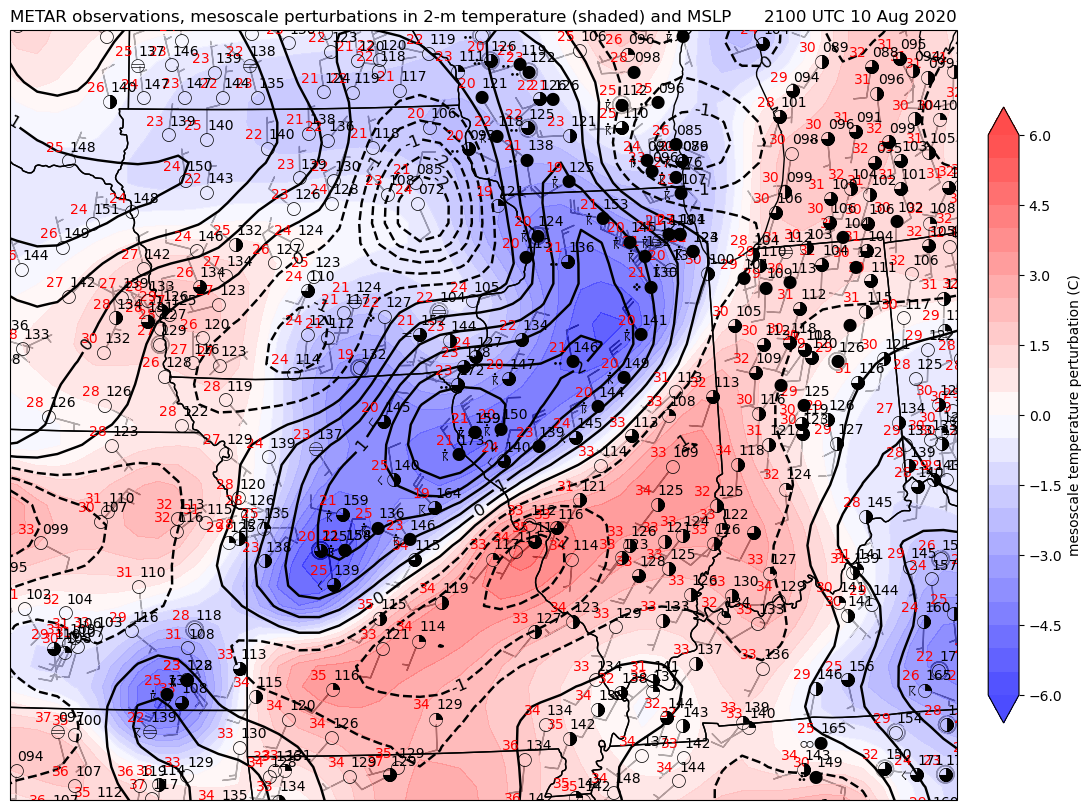

In [15]:
# Change the DPI of the resulting figure. Higher DPI drastically improves the
# look of the text rendering.
plt.rcParams['savefig.dpi'] = 255

# Create the figure and an axes set to the projection.
fig = plt.figure(figsize=(20, 10))
#add_metpy_logo(fig, 1100, 300, size='large')
ax = fig.add_subplot(1, 1, 1, projection=proj)

# Add some various map elements to the plot to make it recognizable.
#ax.add_feature(cfeature.LAND)
#ax.add_feature(cfeature.OCEAN)
#ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS)

# Set plot bounds
#ax.set_extent((-118, -73, 23, 50))
#ax.set_extent((-108,-73, 23, 50))
#ax.set_extent((-97.5,-84,37,44.25))
ax.set_extent(latlon_bounds)

#
# Here's the actual station plot
#

# Start the station plot by specifying the axes to draw on, as well as the
# lon/lat of the stations (with transform). We also the fontsize to 12 pt.
stationplot = StationPlot(ax, data['longitude'].values, data['latitude'].values,
                          clip_on=True, transform=ccrs.PlateCarree(), fontsize=10)

# Plot the temperature and dew point to the upper and lower left, respectively, of
# the center point. Each one uses a different color.
stationplot.plot_parameter('NW', data['air_temperature'].values, color='red')

# A more complex example uses a custom formatter to control how the sea-level pressure
# values are plotted. This uses the standard trailing 3-digits of the pressure value
# in tenths of millibars.
stationplot.plot_parameter('NE', data['air_pressure_at_sea_level'].values,
                           formatter=lambda v: format(10 * v, '.0f')[-3:])

# Plot the cloud cover symbols in the center location. This uses the codes made above and
# uses the `sky_cover` mapper to convert these values to font codes for the
# weather symbol font.
stationplot.plot_symbol('C', data['cloud_coverage'].values, sky_cover)

# Same this time, but plot current weather to the left of center, using the
# `current_weather` mapper to convert symbols to the right glyphs.
stationplot.plot_symbol('W', data['current_wx1_symbol'].values, current_weather)

# Add wind barbs
stationplot.plot_barb(data['eastward_wind'].values, data['northward_wind'].values,
                     length=6)

# Also plot the actual text of the station id. Instead of cardinal directions,
# plot further out by specifying a location of 2 increments in x and 0 in y.
#stationplot.plot_text((1.5, -1), data['station_id'].values, fontsize=8, color='dimgray')

###########
## and 2-m temperature
cs2 = ax.contourf(tempx, tempy, B, 
                  levels=np.arange(-6,6.5,0.5),
                   cmap='bwr', alpha=0.7,
                 extend='both')
cb2 = plt.colorbar(cs2, shrink=0.8, pad=0.02)
cb2.set_label('mesoscale temperature perturbation (C)')

## add pressure contours
cs3 = ax.contour(slpx, slpy, B_press, colors='k', levels=np.arange(-10,10,0.5),
                linewidths=1.75)
ax.clabel(cs3, inline=1, fontsize=12, fmt='%i', colors='k')

plt.title('METAR observations, mesoscale perturbations in 2-m temperature (shaded) and MSLP', loc='left')
plt.title(this_time.strftime("%H%M UTC %d %b %Y"), loc='right')

plt.show()

fig.savefig("mesoscale_"+this_time.strftime("%Y%m%d_%H%M")+".png", bbox_inches='tight', facecolor='white', transparent=False)

### Synoptic field F2

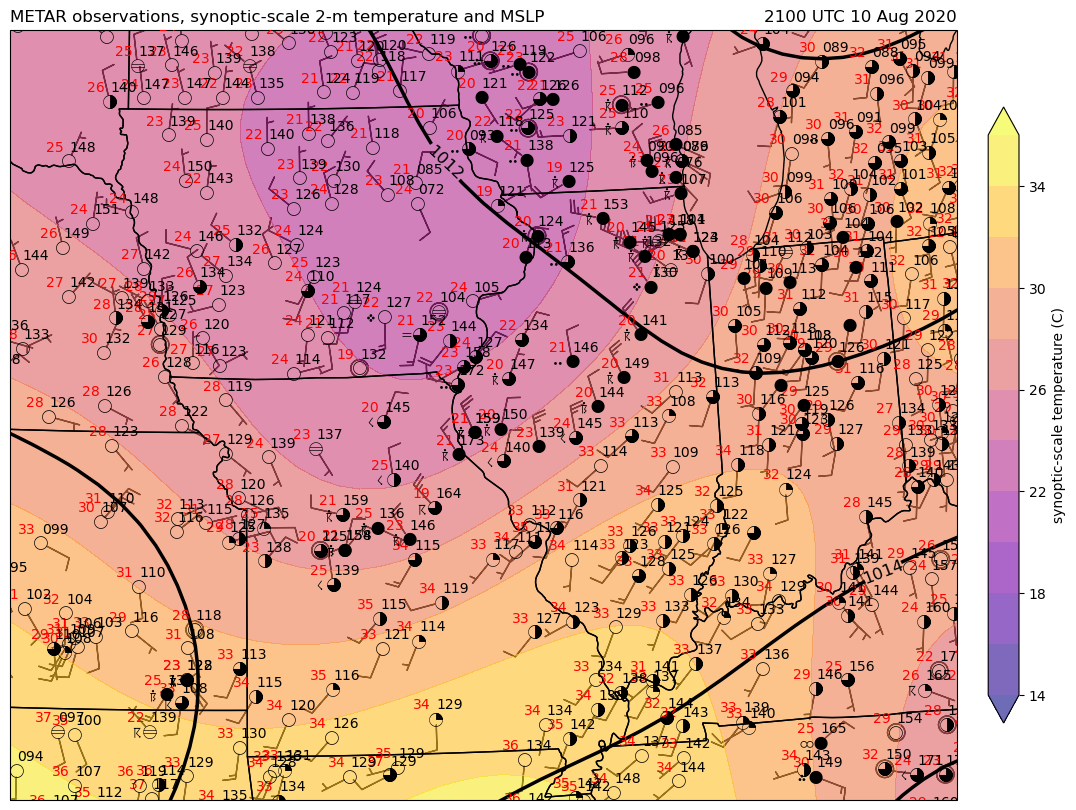

In [16]:
# Change the DPI of the resulting figure. Higher DPI drastically improves the
# look of the text rendering.
plt.rcParams['savefig.dpi'] = 255

# Create the figure and an axes set to the projection.
fig = plt.figure(figsize=(20, 10))
#add_metpy_logo(fig, 1100, 300, size='large')
ax = fig.add_subplot(1, 1, 1, projection=proj)

# Add some various map elements to the plot to make it recognizable.
#ax.add_feature(cfeature.LAND)
#ax.add_feature(cfeature.OCEAN)
#ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS)

# Set plot bounds
#ax.set_extent((-118, -73, 23, 50))
#ax.set_extent((-108,-73, 23, 50))
#ax.set_extent((-106.5,-96,36,42))
#ax.set_extent((-97.5,-84,37,44.25))
ax.set_extent(latlon_bounds)

#
# Here's the actual station plot
#

# Start the station plot by specifying the axes to draw on, as well as the
# lon/lat of the stations (with transform). We also the fontsize to 12 pt.
stationplot = StationPlot(ax, data['longitude'].values, data['latitude'].values,
                          clip_on=True, transform=ccrs.PlateCarree(), fontsize=10)

# Plot the temperature and dew point to the upper and lower left, respectively, of
# the center point. Each one uses a different color.
stationplot.plot_parameter('NW', data['air_temperature'].values, color='red')

# A more complex example uses a custom formatter to control how the sea-level pressure
# values are plotted. This uses the standard trailing 3-digits of the pressure value
# in tenths of millibars.
stationplot.plot_parameter('NE', data['air_pressure_at_sea_level'].values,
                           formatter=lambda v: format(10 * v, '.0f')[-3:])


# Plot the cloud cover symbols in the center location. This uses the codes made above and
# uses the `sky_cover` mapper to convert these values to font codes for the
# weather symbol font.
stationplot.plot_symbol('C', data['cloud_coverage'].values, sky_cover)

# Same this time, but plot current weather to the left of center, using the
# `current_weather` mapper to convert symbols to the right glyphs.
stationplot.plot_symbol('W', data['current_wx1_symbol'].values, current_weather)

# Add wind barbs
stationplot.plot_barb(data['eastward_wind'].values, data['northward_wind'].values,
                     length=6)

# Also plot the actual text of the station id. Instead of cardinal directions,
# plot further out by specifying a location of 2 increments in x and 0 in y.
#stationplot.plot_text((1.5, -1), data['station_id'].values, fontsize=8, color='dimgray')

###########
## and 2-m temperature
cs2 = ax.contourf(tempx, tempy, temp_barnes_f2, 
                  levels=list(range(14,38,2)),
                   cmap='plasma', alpha=0.6,
                 extend='both')
cb2 = plt.colorbar(cs2, shrink=0.8, pad=0.02)
cb2.set_label('synoptic-scale temperature (C)')


cs3 = ax.contour(slpx, slpy, slp_barnes_f2, colors='k',
                 linewidths=2.5,
                 levels=np.arange(972,1040,2))
ax.clabel(cs3, inline=1, fontsize=12, fmt='%i', colors='k')

plt.title('METAR observations, synoptic-scale 2-m temperature and MSLP', loc='left')
plt.title(this_time.strftime("%H%M UTC %d %b %Y"), loc='right')

plt.show()

fig.savefig("synoptic_"+this_time.strftime("%Y%m%d_%H%M")+".png", bbox_inches='tight', facecolor='white', transparent=False)

### Sum of B and F2 (full analysis)

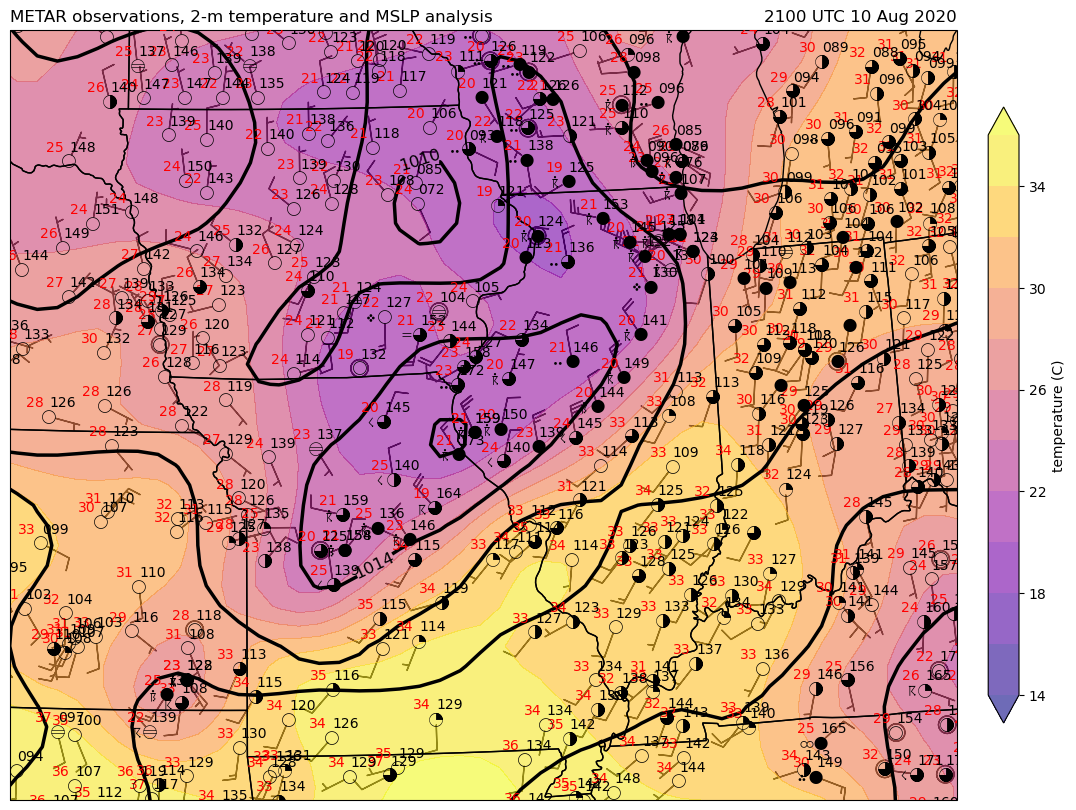

In [17]:
# Change the DPI of the resulting figure. Higher DPI drastically improves the
# look of the text rendering.
plt.rcParams['savefig.dpi'] = 255

# Create the figure and an axes set to the projection.
fig = plt.figure(figsize=(20, 10))
#add_metpy_logo(fig, 1100, 300, size='large')
ax = fig.add_subplot(1, 1, 1, projection=proj)

# Add some various map elements to the plot to make it recognizable.
#ax.add_feature(cfeature.LAND)
#ax.add_feature(cfeature.OCEAN)
#ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS)

# Set plot bounds
#ax.set_extent((-118, -73, 23, 50))
#ax.set_extent((-108,-73, 23, 50))
#ax.set_extent((-106.5,-96,36,42))
#ax.set_extent((-98.5,-86,38.5,45))
#ax.set_extent((-97.5,-84,37,44.25))
ax.set_extent(latlon_bounds)

#
# Here's the actual station plot
#

# Start the station plot by specifying the axes to draw on, as well as the
# lon/lat of the stations (with transform). We also the fontsize to 12 pt.
stationplot = StationPlot(ax, data['longitude'].values, data['latitude'].values,
                          clip_on=True, transform=ccrs.PlateCarree(), fontsize=10)

# Plot the temperature and dew point to the upper and lower left, respectively, of
# the center point. Each one uses a different color.
stationplot.plot_parameter('NW', data['air_temperature'].values, color='red')

# A more complex example uses a custom formatter to control how the sea-level pressure
# values are plotted. This uses the standard trailing 3-digits of the pressure value
# in tenths of millibars.
stationplot.plot_parameter('NE', data['air_pressure_at_sea_level'].values,
                           formatter=lambda v: format(10 * v, '.0f')[-3:])

# Plot the cloud cover symbols in the center location. This uses the codes made above and
# uses the `sky_cover` mapper to convert these values to font codes for the
# weather symbol font.
stationplot.plot_symbol('C', data['cloud_coverage'].values, sky_cover)

# Same this time, but plot current weather to the left of center, using the
# `current_weather` mapper to convert symbols to the right glyphs.
stationplot.plot_symbol('W', data['current_wx1_symbol'].values, current_weather)

# Add wind barbs
stationplot.plot_barb(data['eastward_wind'].values, data['northward_wind'].values,
                     length=6)

# Also plot the actual text of the station id. Instead of cardinal directions,
# plot further out by specifying a location of 2 increments in x and 0 in y.
#stationplot.plot_text((1.5, -1), data['station_id'].values, fontsize=8, color='dimgray')

###########
## and 2-m temperature
cs2 = ax.contourf(tempx, tempy, temp_barnes_f2 + B, 
                  levels=list(range(14,38,2)),
                   cmap='plasma', alpha=0.6,
                 extend='both')
cb2 = plt.colorbar(cs2, shrink=0.8, pad=0.02)
cb2.set_label('temperature (C)')

cs3 = ax.contour(slpx, slpy, slp_barnes_f2 + B_press, colors='k',
                 linewidths=2.5,
                 levels=np.arange(972,1040,2))
ax.clabel(cs3, inline=1, fontsize=12, fmt='%i', colors='k')

plt.title('METAR observations, 2-m temperature and MSLP analysis', loc='left')
plt.title(this_time.strftime("%H%M UTC %d %b %Y"), loc='right')

plt.show()

fig.savefig("synoptic_plus_mesoscale_"+this_time.strftime("%Y%m%d_%H%M")+".png", bbox_inches='tight', facecolor='white', transparent=False)

### and default Barnes analysis for comparison

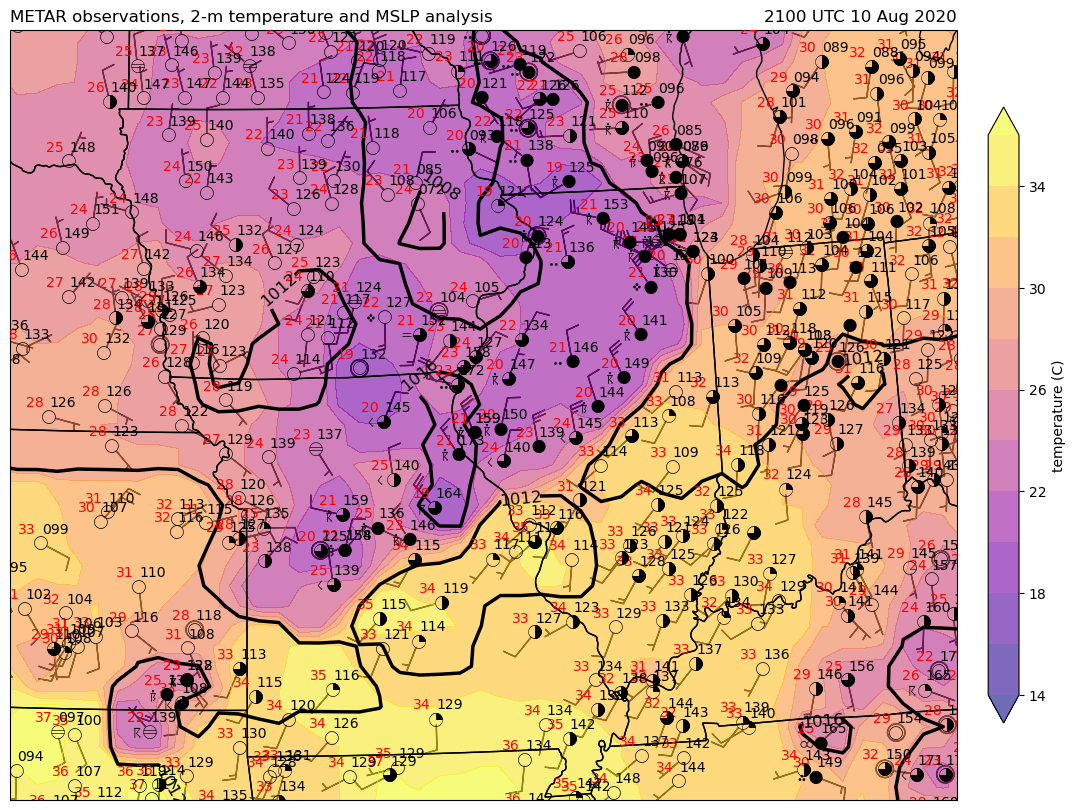

In [18]:
# Change the DPI of the resulting figure. Higher DPI drastically improves the
# look of the text rendering.
plt.rcParams['savefig.dpi'] = 255

# Create the figure and an axes set to the projection.
fig = plt.figure(figsize=(20, 10))
#add_metpy_logo(fig, 1100, 300, size='large')
ax = fig.add_subplot(1, 1, 1, projection=proj)

# Add some various map elements to the plot to make it recognizable.
#ax.add_feature(cfeature.LAND)
#ax.add_feature(cfeature.OCEAN)
#ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS)

# Set plot bounds
#ax.set_extent((-118, -73, 23, 50))
#ax.set_extent((-108,-73, 23, 50))
#ax.set_extent((-106.5,-96,36,42))
#ax.set_extent((-97.5,-84,37,44.25))
ax.set_extent(latlon_bounds)

#
# Here's the actual station plot
#

# Start the station plot by specifying the axes to draw on, as well as the
# lon/lat of the stations (with transform). We also the fontsize to 12 pt.
stationplot = StationPlot(ax, data['longitude'].values, data['latitude'].values,
                          clip_on=True, transform=ccrs.PlateCarree(), fontsize=10)

# Plot the temperature and dew point to the upper and lower left, respectively, of
# the center point. Each one uses a different color.
stationplot.plot_parameter('NW', data['air_temperature'].values, color='red')

# A more complex example uses a custom formatter to control how the sea-level pressure
# values are plotted. This uses the standard trailing 3-digits of the pressure value
# in tenths of millibars.
stationplot.plot_parameter('NE', data['air_pressure_at_sea_level'].values,
                           formatter=lambda v: format(10 * v, '.0f')[-3:])

# Plot the cloud cover symbols in the center location. This uses the codes made above and
# uses the `sky_cover` mapper to convert these values to font codes for the
# weather symbol font.
stationplot.plot_symbol('C', data['cloud_coverage'].values, sky_cover)

# Same this time, but plot current weather to the left of center, using the
# `current_weather` mapper to convert symbols to the right glyphs.
stationplot.plot_symbol('W', data['current_wx1_symbol'].values, current_weather)

# Add wind barbs
stationplot.plot_barb(data['eastward_wind'].values, data['northward_wind'].values,
                     length=6)

# Also plot the actual text of the station id. Instead of cardinal directions,
# plot further out by specifying a location of 2 increments in x and 0 in y.
#stationplot.plot_text((1.5, -1), data['station_id'].values, fontsize=8, color='dimgray')

###########
## and 2-m temperature
#cs2 = ax.contour(tempx, tempy, temp, colors='r', 
#                 linewidths=1.5, levels=list(range(-30,33,2)))
#ax.clabel(cs2, inline=1, fontsize=12, fmt='%i', colors='r')

cs2 = ax.contourf(tempx, tempy, temp, 
                  levels=list(range(14,38,2)),
                   cmap='plasma', alpha=0.6,
                 extend='both')
cb2 = plt.colorbar(cs2, shrink=0.8, pad=0.02)
cb2.set_label('temperature (C)')

cs3 = ax.contour(slpx, slpy, slp, colors='k',
                 linewidths=2.5,
                 levels=np.arange(972,1040,4))
ax.clabel(cs3, inline=1, fontsize=12, fmt='%i', colors='k')

plt.title('METAR observations, 2-m temperature and MSLP analysis', loc='left')
plt.title(this_time.strftime("%H%M UTC %d %b %Y"), loc='right')

plt.show()

fig.savefig("barnes_default_"+this_time.strftime("%Y%m%d_%H%M")+".png", bbox_inches='tight', facecolor='white', transparent=False)

## Can also plot the response functions to see what they look like
Compare to Fig. 1 of Maddox (1980)

Set up an index of lambda (wavelength)

In [19]:
lam = np.arange(0,4200,100)
lam

array([   0,  100,  200,  300,  400,  500,  600,  700,  800,  900, 1000,
       1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100,
       2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200,
       3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100])

/var/folders/75/5p7qdm_177xcdzfy73vdj1rh0001bx/T/ipykernel_95102/3269841538.py:2: RuntimeWarning: divide by zero encountered in divide
  resp1 = np.exp((-np.pi**2)*(4*c1_km2)/(lam**2))
/var/folders/75/5p7qdm_177xcdzfy73vdj1rh0001bx/T/ipykernel_95102/3269841538.py:3: RuntimeWarning: divide by zero encountered in power
  resp1 = resp1*(1+resp1**(g1-1)-resp1**g1)
/var/folders/75/5p7qdm_177xcdzfy73vdj1rh0001bx/T/ipykernel_95102/3269841538.py:3: RuntimeWarning: invalid value encountered in multiply
  resp1 = resp1*(1+resp1**(g1-1)-resp1**g1)
/var/folders/75/5p7qdm_177xcdzfy73vdj1rh0001bx/T/ipykernel_95102/3269841538.py:6: RuntimeWarning: divide by zero encountered in divide
  resp2 = np.exp((-np.pi**2)*(4*c2_km2)/(lam**2))


Text(0, 0.5, 'response')

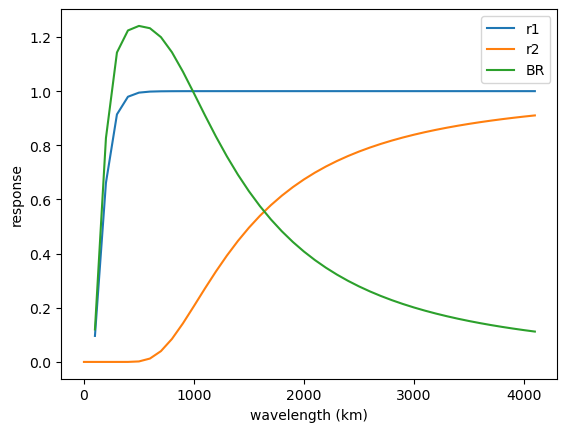

In [20]:
## F1 function
resp1 = np.exp((-np.pi**2)*(4*c1_km2)/(lam**2))
resp1 = resp1*(1+resp1**(g1-1)-resp1**g1)

## F2 function
resp2 = np.exp((-np.pi**2)*(4*c2_km2)/(lam**2))
resp1 = resp1*(1+resp1**(g2-1)-resp1**g2)

r1 = pd.DataFrame(resp1,lam, columns=['r1'])
r2 = pd.DataFrame(resp2,lam, columns=['r2'])
r = r1.join(r2)

r['BR'] = 1.25*(r.r1 - r.r2)

r.plot()
plt.xlabel("wavelength (km)")
plt.ylabel("response")

In [21]:
r

,r1,r2,BR
0,NaN,0.000000e+00,NaN
100,0.096031,2.624003e-69,0.120039
200,0.661399,7.157166e-18,0.826749
300,0.914156,2.398197e-08,1.142694
400,0.979333,5.172319e-05,1.224101
500,0.994501,1.806170e-03,1.240869
600,0.998328,1.244432e-02,1.232355
700,0.999424,3.984621e-02,1.199472
800,0.999778,8.480497e-02,1.143717
900,0.999907,1.423379e-01,1.071961
